In [281]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 2

@author: yaning
"""

import importlib
import numpy as np
import matplotlib.pyplot as plt
import pickle

# my own class files
import with_learning.learning_NN.Receptors as Receptors
import with_learning.learning_NN.Network as Network


importlib.reload(Receptors)
importlib.reload(Network)

path = "/home/yaning/Documents/Spiking_NN/with_learning/"

In [282]:
pointCount = 6500
deltaTms = 0.05
times = np.arange(pointCount) * deltaTms
initial_Vm = 1.3458754117369027

In [283]:
# instead of using control i write those two functions :(have to copy it everytime i run)
all_synapses = []

def create_synapse(send_neuron, receive_neuron, type):
    
    # create receptors accordingly
    if type == "AMPA":
        # temporal solution for weight randomise
        # Receptors.LigandGatedChannelFactory.set_params()
        ampa_receptor = Receptors.AMPA(0.00401, 1, -70, 1.35, 0.9, 1, 1, 1, 12, 10, 20, 10, 35, 7, 0.7, "AMPA")
        synapse = Network.Synapse(0.05, 0, send_neuron, receive_neuron, ampa_receptor)
        
    elif type == "AMPA+NMDA":
        # Receptors.LigandGatedChannelFactory.set_params()
        ampa_receptor = Receptors.AMPA(0.00072, 1, -70, 1.35, 0.9, 1, 1, 1, 12, 10, 20, 10, 35, 7, 0.7, "AMPA")
        nmda_receptor = Receptors.NMDA(0.0012, 1, -70, 1.35, 0.9, 1, 1, 1, 12, 10, 20, 10, 15, 7, 0.7, "NMDA")
        synapse = Network.Synapse(0.05, 0, send_neuron, receive_neuron, ampa_receptor, nmda_receptor)
    
    elif type == "GABA":
        # Receptors.LigandGatedChannelFactory.set_params()
        # print(Receptors.LigandGatedChannelFactory.w_init_GABA)
        gaba_receptor = Receptors.GABA(0.004, 1, -140, 1.35, 0.9, 1, 1, 1, 12, 10, 20, 10, 20, 7, 0.7, "GABA")
        synapse = Network.Synapse(0.05, 0, send_neuron, receive_neuron, gaba_receptor)

    send_neuron.outgoing_synapses.append(synapse)
    receive_neuron.incoming_synapses.append(synapse)

    all_synapses.append(synapse)

def update_synapse_initial_values(infer_params):
    for synapse in all_synapses:
        for receptor in synapse.receptors:
            receptor.Vm = initial_Vm
            receptor.gP = 1
            
            receptor.e = infer_params["e"]
            receptor.u_se = infer_params["u_se"]
            receptor.g_decay = infer_params["g_decay"]
            receptor.g_rise = infer_params["g_rise"]
            receptor.w = infer_params["w"]
            receptor.tau_rec = infer_params["tau_rec"]
            receptor.tau_pre = infer_params["tau_pre"]
            receptor.tau_post = infer_params["tau_post"]

            if receptor.label == "GABA":
                receptor.gMax = infer_params["gMax_GABA"]
                receptor.tau_decay = infer_params["tau_decay_GABA"]
                receptor.tau_rise = infer_params["tau_rise_GABA"]
            
            elif receptor.label == "NMDA":
                receptor.tau_decay = infer_params["tau_decay_NMDA"]
                receptor.tau_rise = infer_params["tau_rise_NMDA"]
            
            elif receptor.label == "AMPA":
                receptor.tau_decay = infer_params["tau_decay_AMPA"]
                receptor.tau_rise = infer_params["tau_rise_AMPA"]

In [284]:
neuron_0 =  Network.Neuron(deltaTms, 0, initial_Vm, "neuron_0")
neuron_1 =  Network.Neuron(deltaTms, 0, initial_Vm, "neuron_1")
neurons = [neuron_0, neuron_1]

In [285]:
create_synapse(neuron_0, neuron_1, "AMPA")

In [286]:
all_currents = []
ion_currents = []

In [287]:
temp = np.full(pointCount, False)

In [288]:
temp.shape

(6500,)

In [289]:
temp[1000:1046] = True

In [290]:
# run
for t in range(pointCount):
    if temp[t]:
        neuron_0.sending_signal()
        neuron_0.fire_tstep.append(t)

    # update the synapse states then each neuron
    num_cycle = 0
    for neuron in neurons[1:]:
        neuron.check_firing(t)
        error_code, ion_I = neuron.update()
        # if num_cycle == 4:
        all_currents.append(neuron.I)
        ion_currents.append(ion_I)
        # all_voltages.append(neuron.Vm)
        num_cycle += 1
        
    # set the synapse states back to 0
    for synapse in all_synapses:
        synapse.state = 0


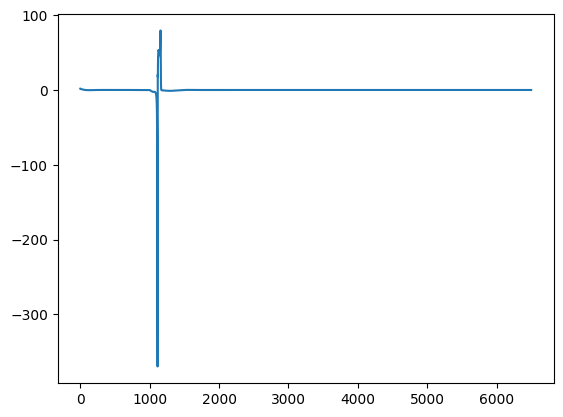

In [291]:
plt.plot(all_currents, label="output")